<Body>   
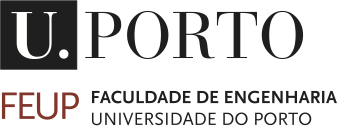   
<h1> <b>Advanced Topics on Machine Learning </b> </h1>
<p><b>Cátia Teixeira</b> (200808037) | <b>Henrique Bastos</b> (202204383) | <b>Ian Karkles</b> (202200596) | <b>Vitor Pereira</b> (202210497)
<p>Master in Data Science and Engineering</p>
</Body>
Faculdade de Engenharia da Universidade do Porto

---

# Data augmentation using cGAN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torchsummary import summary
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from torch.utils.data import SubsetRandomSampler, DataLoader, Dataset
from sklearn.model_selection import train_test_split

## Data preprocessing

In [2]:
df = pd.read_csv('/Users/henriqueribeiro/Downloads/creditcard.csv')

In [48]:
class MyDataset(Dataset):
 
  def __init__(self, path):
    scaler = StandardScaler()
    df = pd.read_csv(path)
 
    x = df.iloc[:, 0:-1].values
    y = df.iloc[:, -1].values

    y = np.reshape(y, (1,-1))
    
    # Standardize data
    x = scaler.fit_transform(x)
    y = scaler.fit_transform(y)
 
    self.x_data=torch.tensor(x,dtype=torch.float32)
    self.y_data=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_data)
   
  def __getitem__(self,idx):
    return self.x_data[idx],self.y_data[idx]

creditData = MyDataset('creditcard.csv')

In [7]:
def split_dataset(data, split_size):

  if not isinstance(split_size, float):
    raise TypeError("split_size must be a float")

  # divide dataset into train-test subsets
  indices = list(range(len(data)))
  np.random.shuffle(indices, )

  data_size = split_size * len(indices)
  split = int(np.floor(data_size))
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  print(f'Training size: {len(train_idx)} \nTest size: {len(test_idx)}')

  return train_sampler, test_sampler


train, test = split_dataset(creditData.x_data, 0.2)

Training size: 227846 
Test size: 56961


In [61]:
def split_dataset(dataset, split_size):

    if not isinstance(split_size, float):
        raise TypeError("split_size must be a float")

    # divide dataset into train-test subsets
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    data_size = split_size * len(indices)
    split = int(np.floor(data_size))
    train_idx, test_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    print(f'Training size: {len(train_idx)} \nTest size: {len(test_idx)}')

    return train_sampler, test_sampler

# Create an instance of MyDataset
creditData = MyDataset('creditcard.csv')

# Pass the entire dataset to the split_dataset function
train_sampler, test_sampler = split_dataset(creditData, 0.2)


Training size: 1 
Test size: 0


In [58]:
train_dataloader = DataLoader(creditData, batch_size=64, sampler=train)
test_dataloader = DataLoader(creditData, batch_size=64, sampler=test)

In [8]:
x_train_dataloader = DataLoader(creditData.x_data, batch_size=64, sampler=train)
y_train_dataloader = DataLoader(creditData.y_data, batch_size=64, sampler=train)

x_test_dataloader = DataLoader(creditData.x_data, batch_size=64, sampler=test)
y_test_dataloader = DataLoader(creditData.y_data, batch_size=64, sampler=test)

In [31]:
# class myDataset(Dataset):
#     def __init__(self, path):
#         df = pd.read_csv(path)
#         df_fraud = df[df['Class'] == 1]
#         df_non_fraud = df[df['Class'] == 0]

#         # Split features and labels before splitting into train and test
#         x_fraud = df_fraud.drop(['Class'], axis=1)
#         y_fraud = df_fraud['Class']
#         x_non_fraud = df_non_fraud.drop(['Class'], axis=1)
#         y_non_fraud = df_non_fraud['Class']

#         # Create training and test dataset from df_fraud and df_non_fraud
#         train_size_fraud = int(0.8 * len(df_fraud))
#         test_size_fraud = len(df_fraud) - train_size_fraud

#         train_size_non_fraud = int(0.8 * len(df_non_fraud))
#         test_size_non_fraud = len(df_non_fraud) - train_size_non_fraud

#         # Combine features and labels and convert to list of tuples
#         fraud_data = list(zip(x_fraud.values, y_fraud.values))
#         non_fraud_data = list(zip(x_non_fraud.values, y_non_fraud.values))

#         #convert fraud_data and non_fraud_data to tensors
#         # fraud_data = torch.tensor(fraud_data)
#         # non_fraud_data = torch.tensor(non_fraud_data)


#         # Split the data
#         self.train_fraud, self.test_fraud = torch.utils.data.random_split(fraud_data, [train_size_fraud, test_size_fraud])
#         self.train_non_fraud, self.test_non_fraud = torch.utils.data.random_split(non_fraud_data, [train_size_non_fraud, test_size_non_fraud])

#         data = []
#         for i in range(len(self.train_fraud)):
#             teste = self.train_fraud[i]
#             # You might need to preprocess 'data' here, depending on your dataset's structure
#             data.append(teste)
#         self.train_fraud = data

#         # #convert to tensors
#         self.train_fraud = torch.tensor(self.train_fraud)
#         # self.test_fraud = torch.tensor(self.test_fraud)
#         # self.train_non_fraud = torch.tensor(self.train_non_fraud)
#         # self.test_non_fraud = torch.tensor(self.test_non_fraud)

#     def __len__(self):
#         return len(self.train_fraud)

#     def __getitem__(self, index):
#         return self.train_fraud[index], self.test_fraud[index], self.train_non_fraud[index], self.test_non_fraud[index]

# # Create dataset instance
# dataset = myDataset('/Users/henriqueribeiro/Downloads/creditcard.csv')


## Conditional Generative Adversarial Network

### Architecture

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, nr_features)
        )
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, nr_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nr_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)

        return torch.sigmoid(x)

In [11]:
#define device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

latent_dim = 7
nr_features = 7

#create optimizer for the generator
generator = Generator(latent_dim, nr_features).to(device)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)

#create optimizer for the descriminator
discriminator = Discriminator(nr_features)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

print(f"Using {device} device")


Using cpu device


In [12]:
print('\t\t\tGenerator')
summary(generator, input_size=(latent_dim,))

			Generator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             128
              ReLU-2                   [-1, 16]               0
            Linear-3                   [-1, 32]             544
              ReLU-4                   [-1, 32]               0
            Linear-5                    [-1, 7]             231
Total params: 903
Trainable params: 903
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [13]:
print('\t\t\tDiscriminator')
summary(discriminator, input_size=(nr_features,))

			Discriminator
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]           2,048
              ReLU-2                  [-1, 256]               0
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
           Dropout-6                  [-1, 128]               0
            Linear-7                   [-1, 64]           8,256
              ReLU-8                   [-1, 64]               0
           Dropout-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
          Sigmoid-11                    [-1, 1]               0
Total params: 43,265
Trainable params: 43,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB)

####  Loss Function + Device + Reset Gradients Funct.

In [15]:
#define device
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def reset_grad():
    discriminator_optimizer.zero_grad()
    generator_optimizer.zero_grad()

criterion = nn.BCELoss()

In [16]:
def train_generator(opt_g, cur_batch_size, criterion):
    # Clear generator gradients
    opt_g.zero_grad()
    
   
    fake_targets = torch.ones((cur_batch_size),  device = device)
    
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    g_loss = criterion(fake_preds, fake_targets)

    g_loss.backward()
    opt_g.step()
    
    return g_loss

In [17]:
def train_discriminator(real_data, opt_d, cur_batch_size):
    # Reset gradients
    opt_d.zero_grad()
    
   
    #real_labels = df_fraud['Class'].to_numpy() #sendo que estamos 
    
    real_labels = torch.ones((cur_batch_size), device=device)
    
    real_preds = discriminator(real_data).reshape(-1)
    d_loss_real = criterion(real_preds, real_labels)
    
    fake_labels = torch.zeros((cur_batch_size),  device = device)
    # random noise from uniform distribution
    latent_space_samples = torch.randn((cur_batch_size, latent_dim),  device = device)
    
    generated_data = generator(latent_space_samples)  # fake data generated by generator
    fake_preds = discriminator(generated_data).reshape(-1)
    d_loss_fake = criterion(fake_preds, fake_labels)
    
    loss = d_loss_real + d_loss_fake

    # Compute gradients
    loss.backward()
    # Adjust the parameters using backprop
    opt_d.step()
    
        
    return loss

In [59]:
def epoch_iter(num_epochs):
    losses_gen = []
    losses_dis = []
    print('Start training...')
    for epoch in range(num_epochs):
        for step, (real_data, real_labels) in enumerate(train_dataloader):
            print(real_data)
            cur_batch_size = real_data.shape[0]
            # Train generator and discriminator
            gen_loss = train_generator(generator_optimizer, cur_batch_size)
            print(f'Generator loss: {gen_loss:.3f}')
            dis_loss = train_discriminator(real_data, discriminator_optimizer, cur_batch_size)
            print(f'Discriminator loss {dis_loss:.3f}')

            losses_gen.append(gen_loss)
            losses_dis.append(dis_loss)



In [22]:
def epoch_iter(num_epochs):
    losses_gen = []
    losses_dis = []
    print('Start training...')
    for epoch in range(num_epochs):
        for batch_idx, batch in enumerate(x_train_dataloader):
            # If your batch has both data and labels
            if len(batch) == 2:
                real_data, real_labels = batch
            # If your batch has only data
            elif len(batch) == 1:
                real_data = batch
                real_labels = None  # If your data doesn't have labels
            else:
                raise ValueError("Unexpected number of elements in the batch.")
            
            cur_batch_size = real_data.shape[0]
            # Train generator and discriminator
            gen_loss = train_generator(generator_optimizer, cur_batch_size)
            print(f'Generator loss: {gen_loss:.3f}')
            dis_loss = train_discriminator(real_data, discriminator_optimizer, cur_batch_size)
            print(f'Discriminator loss {dis_loss:.3f}')

            losses_gen.append(gen_loss)
            losses_dis.append(dis_loss)

In [60]:
epoch_iter(10)

Start training...


IndexError: index 243230 is out of bounds for dimension 0 with size 1